# Deep learning for Natural Language Processing


 * Simple text representations, bag of words
 * Word embedding and... not just another word2vec this time
 * 1-dimensional convolutions for text
 * Aggregating several data sources "the hard way"
 * Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning
 

Special thanks to Irina Golzmann for help with technical part.

# NLTK

You will require nltk v3.2 to solve this assignment

__It is really important that the version is 3.2, otherwize russian tokenizer might not work__

Install/update
* `sudo pip install --upgrade nltk==3.2`
* If you don't remember when was the last pip upgrade, `sudo pip install --upgrade pip`

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

# For students with low-RAM machines
 * This assignment can be accomplished with even the low-tier hardware (<= 4Gb RAM) 
 * If that is the case, turn flag "low_RAM_mode" below to True
 * If you have around 8GB memory, it is unlikely that you will feel constrained by memory.
 * In case you are using a PC from last millenia, consider setting very_low_RAM=True

In [3]:
low_RAM_mode = False
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [5]:
if not low_RAM_mode:
    # a lot of ram
    print 'yeah bitch'
    df = pd.read_csv("data/avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
 

yeah bitch


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [6]:
print "Blocked ratio",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio 0.0688212106553
Count: 3995803


# Balance-out the classes
* Vast majority of data samples are non-prohibited
 * 250k banned out of 4kk
 * Let's just downsample random 250k legal samples to make further steps less computationally demanding
 * If you aim for high Kaggle score, consider a smarter approach to that.


In [7]:
import random

D = df

not_blocked = np.array(df.is_blocked == 0).astype('int').nonzero()[0]
blocked = np.array(df.is_blocked == 1).astype('int').nonzero()[0]

df_b = df.iloc[blocked]
df_nb = df.iloc[not_blocked]

sdf = pd.concat([df_b.sample(len(df_nb), replace=True), df_nb])

In [8]:
len(sdf)

7441614

In [10]:
df = sdf

print "Blocked ratio:",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio: 0.5
Count: 7441614


In [11]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
#assert len(df) <= 560000

print "All tests passed"

All tests passed


# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [12]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([D.description.values,D.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

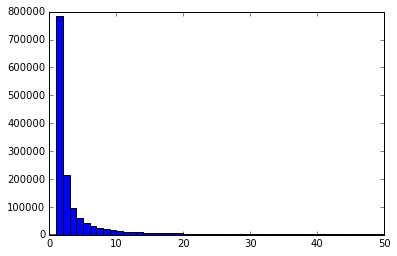

In [13]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [14]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 50
tokens = [token for token in token_counts if token_counts[token] >= min_count]

In [15]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0


In [16]:
print "# Tokens:",len(token_to_id)
if len(token_to_id) < 30000:
    print "Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc"
if len(token_to_id) > 1000000:
    print "Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc"

# Tokens: 95357


### Replace words with IDs
Set a maximum length for titles and descriptions.
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [17]:
from tqdm import tqdm
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in tqdm(strings):
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [18]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

100%|██████████| 7441614/7441614 [00:54<00:00, 136764.48it/s]


### Data format examples


In [19]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (7441614, 15)
Деньги в долг под залог имущества -> [39482 84051 45500 91725 41872  5982     0     0     0     0] ...
Продам пистолет Макаров -> [31394 31263 92465     0     0     0     0     0     0     0] ...
Массажист -> [42809     0     0     0     0     0     0     0     0     0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing.

In [20]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]

In [21]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df[["category","subcategory"]].values

In [22]:
categories = [{"category":d[0], "subcategory":d[1]} for d in data_cat_subcat]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [23]:
df_non_text = pd.merge(df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot)))
del df_non_text["key_0"]

# Split data into training and test

In [24]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = np.array(df_non_text.astype('float32'))

In [25]:
from sklearn.cross_validation import train_test_split
#Split into training and test set.


#Difficulty selector:
#Easy: split randomly
#Medium: select test set items that have item_ids strictly above that of training set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard

title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = train_test_split(title_tokens, desc_tokens, df_non_text, target)

## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [27]:
save_prepared_data = True #save
read_prepared_data = False #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)


if save_prepared_data:
    print "Saving preprocessed data (may take up to 3 minutes)"
    data_tuple = title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts
    import pickle
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "готово"
    
elif read_prepared_data:
    print "Reading saved data..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)


        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
        
    print "done"

Saving preprocessed data (may take up to 3 minutes)
готово


# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles
 * cnn+global max or RNN
* Separate input for description
 * cnn+global max or RNN
* Separate input for categorical features
 * обычные полносвязные слои или какие-нибудь трюки
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal with binary_crossentropy
 * 2 softmax with categorical_crossentropy - essentially the same as previous one
 * 1 neuron without nonlinearity (lambda x: x) +  hinge loss
 

In [28]:
#libraries
import lasagne
from theano import tensor as T
import theano

Using gpu device 1: Quadro K4200 (CNMeM is enabled with initial size: 30.0% of memory, CuDNN 4007)


In [29]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

# NN architecture

In [ ]:
len(token_to_id)

In [30]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [61]:
# Descriptions

N_FILTERS = 256
FILTER_SIZE = 3
EMBEDDING_SIZE = 128
FC_UNITS = 1024
DROPOUT = 0.2

#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.

descr_nn = lasagne.layers.EmbeddingLayer(descr_inp,
                                         input_size=len(token_to_id)+1,
                                         output_size=EMBEDDING_SIZE)


#reshape from [batch, time, unit] to [batch,unit,time] to allow 1d convolution over time
descr_nn = lasagne.layers.DimshuffleLayer(descr_nn, [0,2,1])

descr_nn = lasagne.layers.Conv1DLayer(descr_nn, N_FILTERS, FILTER_SIZE)

#descr_nn = lasagne.layers.MaxPool1DLayer(descr_nn, FILTER_SIZE)

#descr_nn = lasagne.layers.Conv1DLayer(descr_nn, N_FILTERS, FILTER_SIZE)

#pool over time
descr_nn = lasagne.layers.GlobalPoolLayer(descr_nn,T.max)

#Possible improvements here are adding several parallel convs with different filter sizes or stacking them the usual way
#1dconv -> 1d max pool ->1dconv and finally global pool 


# Titles
title_nn = lasagne.layers.EmbeddingLayer(title_inp,
                                         input_size=len(token_to_id)+1,
                                         output_size=EMBEDDING_SIZE)

title_nn = lasagne.layers.DimshuffleLayer(title_nn, [0,2,1])

title_nn = lasagne.layers.Conv1DLayer(title_nn, N_FILTERS, FILTER_SIZE)

#title_nn = lasagne.layers.MaxPool1DLayer(title_nn, FILTER_SIZE)

#title_nn = lasagne.layers.Conv1DLayer(title_nn, N_FILTERS, FILTER_SIZE)

title_nn = lasagne.layers.GlobalPoolLayer(title_nn,T.max)

# Non-sequences
cat_nn = lasagne.layers.DenseLayer(cat_inp, FC_UNITS)
cat_nn = lasagne.layers.DenseLayer(cat_nn, FC_UNITS)
#cat_nn = lasagne.layers.DenseLayer(cat_nn, FC_UNITS)

In [62]:
nn = lasagne.layers.ConcatLayer([cat_nn, title_nn, descr_nn])

nn = lasagne.layers.DenseLayer(nn, FC_UNITS)
nn = lasagne.layers.DropoutLayer(nn,p=DROPOUT)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
 * Function description may mention some +-1  limitations - this is not neccessary, at least as long as hinge loss has a __default__ flag `binary = True`

In [48]:
123

123

In [63]:
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)

#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction,target_y).mean()

#Weight optimization step
updates = lasagne.updates.adadelta(loss, weights)

#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#equivalent loss function
det_loss = lasagne.objectives.binary_hinge_loss(det_prediction,target_y).mean()

### Determinitic prediction 
 * In case we use stochastic elements, e.g. dropout or noize
 * Compile a separate set of functions with deterministic prediction (deterministic = True)
 * Unless you think there's no neet for dropout there ofc. Btw is there?

### Coffee-lation

In [64]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [51]:
#average precision at K

from oracle import APatK, score

from IPython import display
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm

In [52]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]
        


### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs

* AUC is the most stable of all three metrics

* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [68]:
123

123

260it [00:32,  7.93it/s]


Val:
	acc: 0.975835755814
	auc: 0.994622895342
Train:
	acc: 0.976517078488
	auc: 0.993384612012


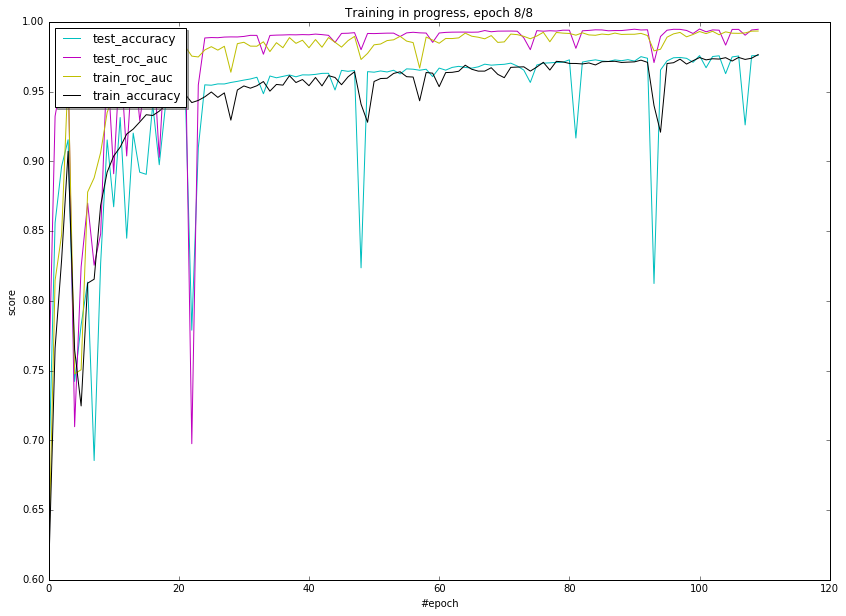

In [70]:
bar.close()

n_epochs = 8
batch_size = 512
minibatches_per_epoch = 128

#rh = []
#ah = []

#trh = []
#tah = []

for i in range(n_epochs):
    
    #training
    epoch_y_true = []
    epoch_y_pred = []
    bar = tqdm(total=2*minibatches_per_epoch)
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(iterate_minibatches(desc_tr,title_tr,
                                                                        nontext_tr,target_tr,
                                                                        batchsize=batch_size,
                                                                        shuffle=True)):
        
        
        bar.update(1)
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    display.clear_output(wait=True)
    plt.figure(figsize=(14, 10))
    
    tac = accuracy_score(epoch_y_true,epoch_y_pred>0.)
    toc = roc_auc_score(epoch_y_true,epoch_y_pred)
    
    trh.append(tac)
    tah.append(toc)
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(iterate_minibatches(desc_ts,title_ts,
                                                                        nontext_ts,target_ts,
                                                                        batchsize=batch_size,
                                                                        shuffle=True)):
        bar.update(1)
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    tasc = accuracy_score(epoch_y_true,epoch_y_pred>0.)
    tras = roc_auc_score(epoch_y_true,epoch_y_pred)
    
    ah.append(tasc)
    rh.append(tras)
    bar.close()
    
    print "Val:"
    print '\tacc:',tasc
    print '\tauc:',tras

    
    print "Train:"
    print '\tacc:',tac
    print '\tauc:',toc
    
    plt.title("Training in progress, epoch " + str(i+1) + '/' + str(n_epochs))
    plt.xlabel("#epoch")
    plt.ylabel("score")
    plt.plot(ah, 'c', label='test_accuracy')
    plt.plot(rh, 'm', label='test_roc_auc')
    plt.plot(tah, 'y', label='train_roc_auc')
    plt.plot(trh, 'k', label='train_accuracy')
    
    legend = plt.legend(loc='upper left', shadow=True)
    
    plt.show()

In [ ]:
print "If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. "

# Final evaluation
Evaluate network over the entire test set

In [72]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in tqdm(enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True))):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

3633it [03:00, 20.36it/s]


Scores:
	loss: 0.0588118834819
	acc: 0.975965756606
	auc: 0.994548710485
	ap@k: 0.998147627369

AUC:
	Пиши статью. (great)

Accuracy:
	Очешуенно! (great)

Average precision at K:
	Засабмить на kaggle! (great) 
	 Нет, ну честно - выкачай avito_test.tsv, засабмить и скажи, что вышло.


# Main task
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther


* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92


* Remember the training, Luke
 * Convolutions, pooling
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
 * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.
 

# A brief report

### I, _____ _____ (group ____) have synthesized an artificial intelligence
 * Whos name - ____ - shall henceforth be feared by generations of humans.
 * Whos fury is beyond all limits, as {he/she} has seen __250 000__ human sins
   * And read every single line __{n_epochs}__ times
 * Whos convolutional gaze is capable of detecting evil with a superhuman performance
   * Accuracy = __
   * AUC  = __
 * And whom i shall unleash upon Earth unless you give me 10 points for that seminar
 
 
{How did you shape the monster?}

# Next time in our show
* Recurrent neural networks
 * How to apply them to practical problems?
 * What else can they do?
 * Why so much hype around LSTM?
* Stay tuned!